# Loading Data

In [149]:
import plotly.io as pio
pio.renderers.default = "notebook"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from matplotlib.ticker import MaxNLocator, FuncFormatter, PercentFormatter
import pycountry_convert as pc

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, r2_score, mean_squared_error, confusion_matrix
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestRegressor

olymp = pd.read_csv("data/athlete_events.csv")
noc_regions = pd.read_csv("data/noc_regions.csv")
olymp.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


# Defining Questions

1. How has athlete participation changed over time across countries and continents? 
    - Method used: Linear regression, cross validated R^2 (fit linear model to line plot of athletes over time)
2. Does delegation size predict medal success? How strongly?
    - Method used: Random Forest Regressor predicting medal counts, cross validation, and feature importance
3. Do host nations experience a measurable boost in performance?
    - Method used: t-test, host vs non-host eda

# Data Collection

### Overview
Our work uses the dataset titled 120 years of Olympic history: athletes and results on kaggle (https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results). This is a public dataset that contaians information information since 1896 to 2016. It was compiled from publicly released Olympic records and digitized historical archives.  The dataset has 271,116 rows where each row is corresponds to an individual athlete.  Because many athletes compete in multiple events, or appear in multiple Olympic years, the dataset is structured at the athlete-event level.  

We also used the accompanying file **`noc_regions.csv`**, which maps NOC codes to standardized country names and geographic regions. This file is essential for correcting historical country names and assigning each entry to a continent.

### Population Represented
- All Olympic Athletes who participated in any Olympic Games from 1896-2016
- Over 200 countries and territories
- Both Summer and Winter Olympics

### Key Features
The dataset contains both categorical variables (e.g., NOC, sport, event, medal type) and numeric variables (e.g., age, height, weight, year):
| Variable                 | Description                                                       |
|--------------------------|-------------------------------------------------------------------|
| **ID**                   | Unique athlete identifier                                         |
| **Name**                 | Athlete name                                                      |
| **Sex**                  | Male/Female                                                       |
| **Age, Height, Weight**  | Demographic and physical information (contains missing values)    |
| **Team / NOC**           | Country team and National Olympic Committee code                  |
| **Games / Year / Season**| Olympic edition metadata                                          |
| **City, Sport, Event**   | Location and competition details                                  |
| **Medal**                | Gold, Silver, Bronze, or NA (no medal)                            | 

### Why this Dataset is Appropriate
- It spans 120 years, enabling long-term trend analysis.
- Medal and participation data allow for predictive modeling.
- Country info allows for aggregation into a country-year dataset, which can be used to study delegation size, medal efficiency, etc.
- The dataset is clean, well-documented, and widely used

# Data Cleaning and Preparation

Because the raw dataset is at the athlete-event level, we had to transform and aggregate the data into a country-year format suitable for statistical modeling.

### 1. Filtering to Summer Olympics Only
Our research questions focus specifically on long-term trends in the Summer Olympics, so we removed all Winter entries

### 2. Standardizing Country and Region Information
The dataset uses NOC codes, which do not always align with modern country names (e.g, URS -> Russia).  We merged the dataset with noc_regions.csv to:
- Map NOCs to standardized country names
- Resolve historical country splits and dissolutions
- Assign each country to a continent
Some countries required manual corrections

### 3. Handling Missing/Irrelevant Features
Several fields such as Age, Height contain substantial missingniss.  Because they're not central to our research, we removed them

### 4. Engineering Medal Related Features
- Medal quality score: `3*gold + 2*silver + 1*bronze`
- Medal efficiency: `medals_per_athlete = n_medals / n_athletes`
- Host indicator: `is_host = 1 if country hosted that year`

### 5. Aggregating Data to Country-Year Level
We aggregated the cleaned athlete-level data by:
- Year
- NOC
- Country
- Continent
For each country-year, we computed:
- Total athletes
- Total medals, gold, silver, bronze
- Medal quality score
- Medal efficiency
- Host indicator

In [150]:
import pycountry_convert as pc # pip install pycountry pycountry_convert

# country mapping (making countries/continents consistent)
def country_to_continent(country):
    """
    Convert country name → continent name using pycountry_convert.
    Returns None if lookup fails.
    """
    try:
        iso = pc.country_name_to_country_alpha2(country)
        cont_code = pc.country_alpha2_to_continent_code(iso)
        return {
            "AF": "Africa",
            "AS": "Asia",
            "EU": "Europe",
            "NA": "North America",
            "OC": "Oceania",
            "SA": "South America"
        }[cont_code]
    except:
        return None

manual_continent_overrides = {
    "UK": "Europe",
    "USA": "North America",
    "Russia": "Europe",    "Serbia and Montenegro": "Europe",
    "Yugoslavia": "Europe",
    "Czechoslovakia": "Europe",
    "Syria": "Asia",
    "Hong Kong": "Asia",
    "Curacao": "North America",
    "Virgin Islands, US": "North America",
    "Virgin Islands, British": "North America",
    "West Indies Federation": "North America",
    "Refugee Olympic Team": None,
    "Individual Olympic Athletes": None,
    "NA": None,
}

def resolve_continent(row):
    country = row["country_name"]
    if pd.isna(country):
        return np.nan

    if country in manual_continent_overrides:
        return manual_continent_overrides[country]
    
    return country_to_continent(country)


host_country_map = {
    1896: "Greece",
    1900: "France",
    1904: "USA",
    1908: "UK",
    1912: "Sweden",
    1920: "Belgium",
    1924: "France",
    1928: "Netherlands",
    1932: "USA",
    1936: "Germany",
    1948: "UK",
    1952: "Finland",
    1956: "Australia",
    1960: "Italy",
    1964: "Japan",
    1968: "Mexico",
    1972: "Germany",
    1976: "Canada",
    1980: "Russia",           # USSR -> Russia
    1984: "USA",
    1988: "South Korea",
    1992: "Spain",
    1996: "USA",
    2000: "Australia",
    2004: "Greece",
    2008: "China",
    2012: "UK",
    2016: "Brazil", # we only have data to 2016
}


In [151]:
olympics_summer = olymp[olymp['Season'] == "Summer"]

# Merge NOC mappings
olympics_summer = olympics_summer.merge(noc_regions, on="NOC", how="left")
olympics_summer.rename(columns={"region": "country_name"}, inplace=True)

print(noc_regions[noc_regions["NOC"] == "GBR"])


olympics_summer["continent"] = olympics_summer.apply(resolve_continent, axis=1)

# Medal quality fields
olympics_summer["has_medal"] = olympics_summer["Medal"].notna().astype(int)
olympics_summer["is_gold"]   = (olympics_summer["Medal"] == "Gold").astype(int)
olympics_summer["is_silver"] = (olympics_summer["Medal"] == "Silver").astype(int)
olympics_summer["is_bronze"] = (olympics_summer["Medal"] == "Bronze").astype(int)

medal_events = olympics_summer.dropna(subset=["Medal"]).copy()

# Count each Event+Medal once (team events => 1 medal)
unique_medals = (
    medal_events.groupby(["Year", "NOC", "country_name", "continent", "Event", "Medal"])
    .size()
    .reset_index(name="count")
)

# Each event-medal = 1 medal irrespective of athletes
unique_medals["medal_unit"] = 1

# Aggregate to country-year
country_year_medals = (
    unique_medals.groupby(["Year", "NOC", "country_name", "continent"])
    .agg(
        n_medals=("medal_unit", "sum"),
        n_gold=("Medal", lambda x: (x == "Gold").sum()),
        n_silver=("Medal", lambda x: (x == "Silver").sum()),
        n_bronze=("Medal", lambda x: (x == "Bronze").sum())
    )
    .reset_index()
)

# Now add athlete counts back in
athlete_counts = (
    olympics_summer.groupby(["Year", "NOC", "country_name", "continent"])
    .agg(n_athletes=("ID", lambda x: x.nunique()))
    .reset_index()
)

# Merge medals + athletes together
country_year = country_year_medals.merge(
    athlete_counts, on=["Year", "NOC", "country_name", "continent"], how="left"
)


country_year["total_medal_quality"] = (
    3 * country_year["n_gold"]
    + 2 * country_year["n_silver"]
    + 1 * country_year["n_bronze"]
)

# Medal efficiency
country_year["medals_per_athlete"] = (
    country_year["n_medals"] / country_year["n_athletes"]
).replace([float("inf"), -float("inf")], pd.NA)

# share of medals by continent over time
medals_continent_year = (
    country_year.groupby(["Year", "continent"])["n_medals"]
    .sum()
    .reset_index()
)

total_medals_year = (
    medals_continent_year.groupby("Year")["n_medals"]
    .sum()
    .reset_index(name="total_medals")
)

medals_continent_year = medals_continent_year.merge(total_medals_year, on="Year")
medals_continent_year["medal_share"] = (
    medals_continent_year["n_medals"] / medals_continent_year["total_medals"]
)

# Percent of athletes per continent each year
percent_athletes_continent_year = (
    country_year.dropna(subset=['continent'])
      .groupby(['continent','Year'], as_index=False)['n_athletes']
      .sum()
)
percent_athletes_continent_year['pct'] = percent_athletes_continent_year.groupby('Year')['n_athletes'].transform(
    lambda x: x / x.sum()
)

# adding host_country to data frame
country_year["host_country"] = country_year["Year"].map(host_country_map)
country_year["is_host"] = (country_year["country_name"] == country_year["host_country"]).astype(int)

    NOC region notes
74  GBR     UK   NaN


# Data Analysis

## EDA

In [152]:
olympics_summer.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Sport,Event,Medal,country_name,notes,continent,has_medal,is_gold,is_silver,is_bronze
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,...,Basketball,Basketball Men's Basketball,NaN,China,NaN,Asia,0,0,0,0
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,...,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN,Asia,0,0,0,0
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,...,Football,Football Men's Football,NaN,Denmark,NaN,Europe,0,0,0,0
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,...,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN,Europe,1,1,0,0
4,8,"Cornelia ""Cor"" Aalten (-Strannood)",F,18.0,168.0,NaN,Netherlands,NED,1932 Summer,1932,...,Athletics,Athletics Women's 100 metres,NaN,Netherlands,NaN,Europe,0,0,0,0


In [153]:
olympics_summer.info()

olympics_summer.describe()
olympics_summer.columns
country_year.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222552 entries, 0 to 222551
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            222552 non-null  int64  
 1   Name          222552 non-null  object 
 2   Sex           222552 non-null  object 
 3   Age           213363 non-null  float64
 4   Height        170695 non-null  float64
 5   Weight        168698 non-null  float64
 6   Team          222552 non-null  object 
 7   NOC           222552 non-null  object 
 8   Games         222552 non-null  object 
 9   Year          222552 non-null  int64  
 10  Season        222552 non-null  object 
 11  City          222552 non-null  object 
 12  Sport         222552 non-null  object 
 13  Event         222552 non-null  object 
 14  Medal         34088 non-null   object 
 15  country_name  222182 non-null  object 
 16  notes         4401 non-null    object 
 17  continent     221242 non-null  object 
 18  has_

Index(['Year', 'NOC', 'country_name', 'continent', 'n_medals', 'n_gold',
       'n_silver', 'n_bronze', 'n_athletes', 'total_medal_quality',
       'medals_per_athlete', 'host_country', 'is_host'],
      dtype='object')

#### Total Athletes Over Time by Continent

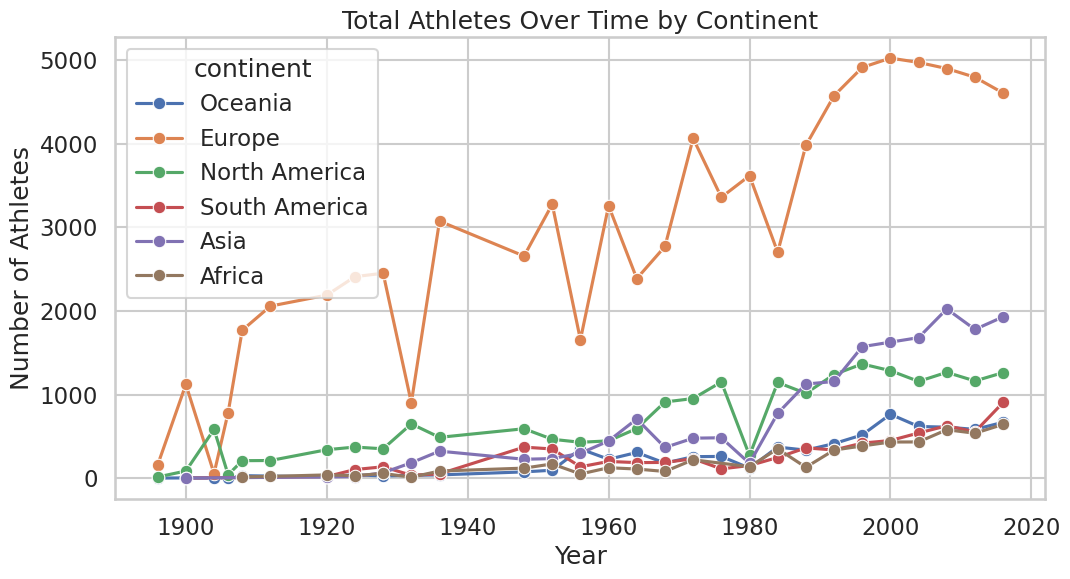

In [154]:
# Participation Trends

# number of athletes over time
plt.figure(figsize=(12,6))
sns.lineplot(
    data=country_year,
    x="Year",
    y="n_athletes",
    hue="continent",
    marker="o",
    estimator="sum",
    errorbar=None
)
plt.title("Total Athletes Over Time by Continent")
plt.ylabel("Number of Athletes")
plt.show()

Athlete participation has substantially increased onver the past century, and every continent shows long-term growth.  Participation from Asia seems to be expanding more rapidly in recent decades

#### Number of Participating Countries Over Time

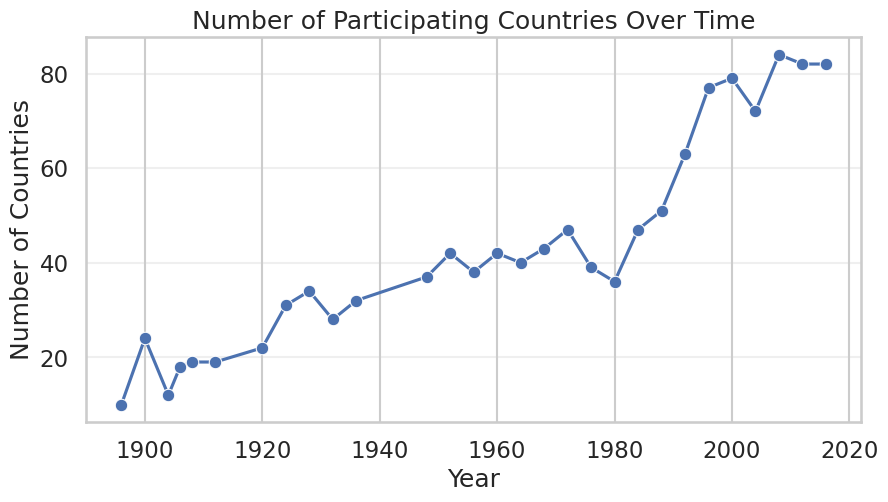

In [155]:
# Number of countries per year
countries_per_year = (
    country_year.groupby("Year")["country_name"]
    .nunique()
    .reset_index(name="n_countries")
)

plt.figure(figsize=(10,5))
sns.lineplot(data=countries_per_year, x="Year", y="n_countries", marker="o")
plt.title("Number of Participating Countries Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Countries")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

The number of participating countries has grown steadily over time. This shows how the Olympics have become increasingly global, with more nations joining the Games each decade. Major jumps correspond to geopilitcal shifts such as decolonization and the rise of newly formed nations.

#### Number of Participating Countries by Continent Over Time

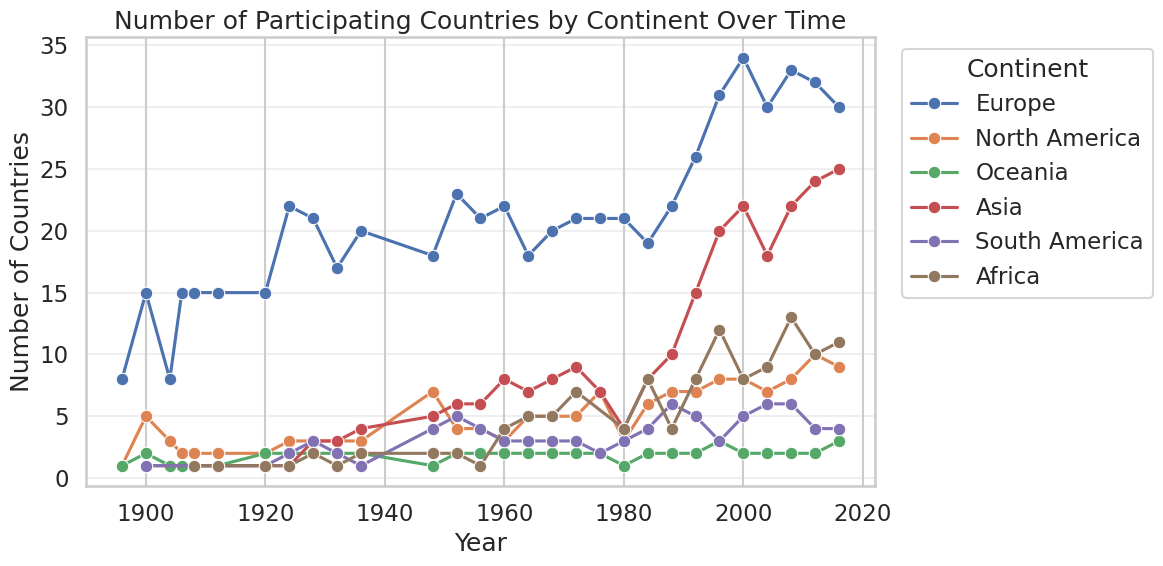

In [156]:
# Number of countries per year by continent
countries_per_year_continent = (
    country_year.groupby(["Year", "continent"])["country_name"]
    .nunique()
    .reset_index(name="n_countries")
)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=countries_per_year_continent,
    x="Year", y="n_countries", hue="continent",
    marker="o"
)
plt.title("Number of Participating Countries by Continent Over Time")
plt.xlabel("Year"); plt.ylabel("Number of Countries")
plt.grid(True, axis='y', alpha=0.3)
plt.legend(title="Continent", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

Every continent shows an increase in the number of countries participating over time, especially after the mid-20th century. This reflects global political changeslike decolonization and a growing worldwide presence in the Olympic Games.

#### Share of Athletes by Continent

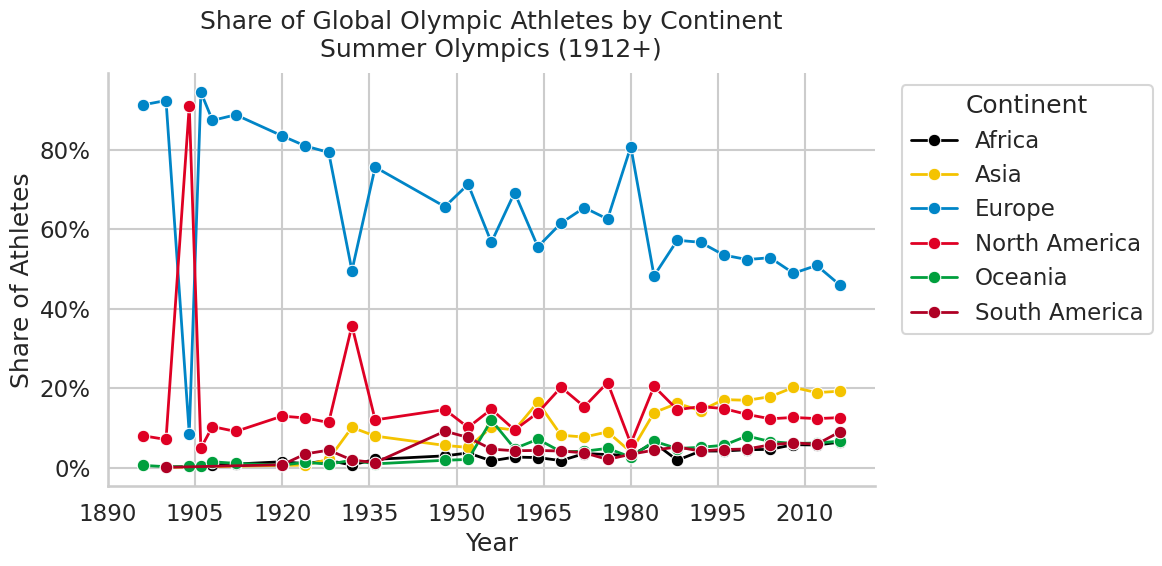

In [157]:
continent_colors = {
    "Europe":   "#0085C7",  # Blue
    "Asia":     "#F4C300",  # Yellow
    "Africa":   "#000000",  # Black
    "Oceania":  "#009F3D",  # Green
    "North America": "#DF0024",  # Red
    "South America": "#AF0024", 

}

# Share of athletes by contient
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=percent_athletes_continent_year, x='Year', y='pct', hue='continent', marker='o', linewidth=2, palette=continent_colors)
ax.set_title("Share of Global Olympic Athletes by Continent\nSummer Olympics (1912+)", pad=12)
ax.set_xlabel("Year"); ax.set_ylabel("Share of Athletes")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(title='Continent', bbox_to_anchor=(1.02,1), loc='upper left')
sns.despine(); plt.tight_layout(); plt.show()

Europe and North America initially made up the majority of Olympic athletes, but their share decreases as participation from Asia, Africa, and South America grows. Over time, the Games become more globally balanced, with newer regions contributing a larger portion of total athletes.

#### Continental Medal Share Over Time

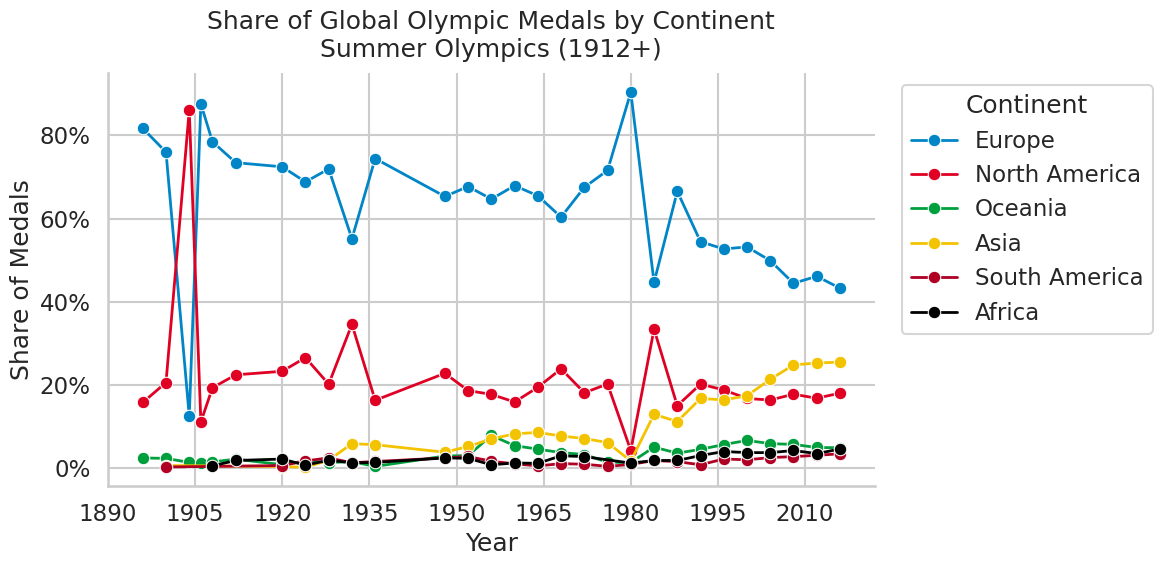

In [158]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(
    data=medals_continent_year,
    x="Year", y="medal_share", hue="continent",
    marker="o", linewidth=2, palette=continent_colors
)
ax.set_title("Share of Global Olympic Medals by Continent\nSummer Olympics (1912+)", pad=12)
ax.set_xlabel("Year")
ax.set_ylabel("Share of Medals")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(title="Continent", bbox_to_anchor=(1.02,1), loc="upper left")
sns.despine(); plt.tight_layout(); plt.show()


Europe has historically had the largest share of Olympic medals, but over time other continents like Asia and North America are gaining a larger share.  This shift reflects increasing global competitiveness and investment in high-performance sports outside traditional power regions like Europe.

#### Medal Efficiency (Medals per Athlete)

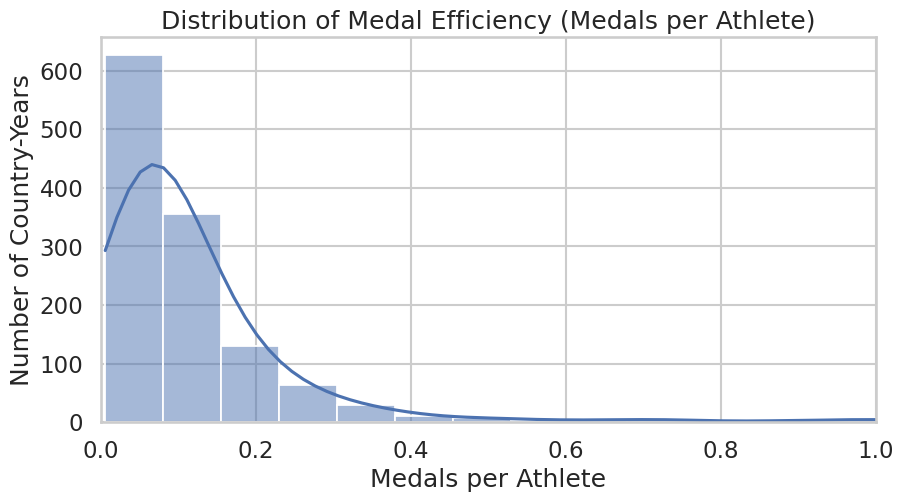

In [159]:
plt.figure(figsize=(10,5))
sns.histplot(
    data=country_year,
    x="medals_per_athlete",
    bins=40,
    kde=True
)
plt.title("Distribution of Medal Efficiency (Medals per Athlete)")
plt.xlabel("Medals per Athlete")
plt.ylabel("Number of Country-Years")
plt.xlim(0, country_year["medals_per_athlete"].quantile(0.99))  # trim crazy outliers
plt.show()

Most countries have a very small number of medals-per-athlete value.  This shows that the majority of nations win relatively few medals relative to delegation size.

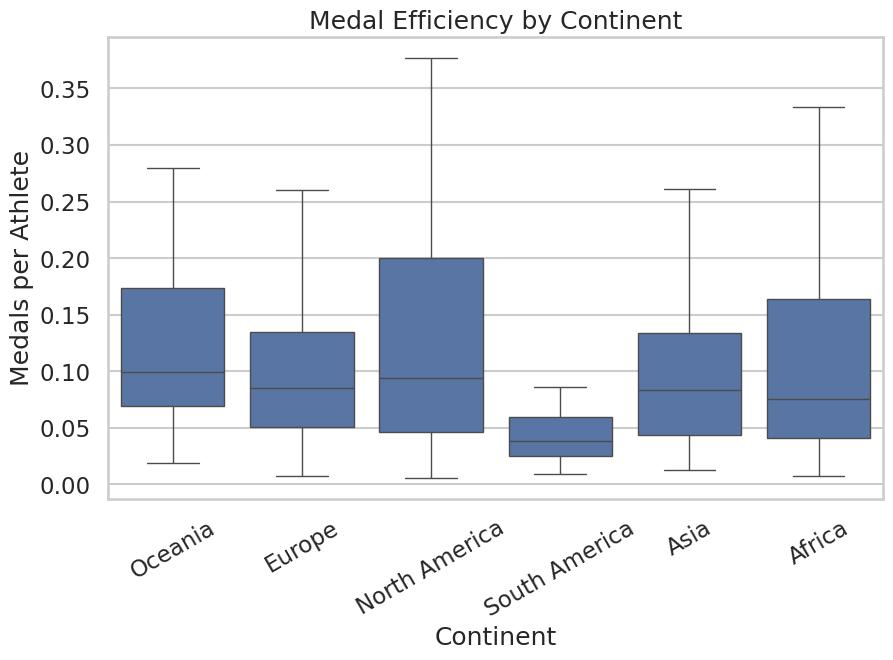

In [160]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=country_year,
    x="continent",
    y="medals_per_athlete",
    showfliers=False
)
plt.title("Medal Efficiency by Continent")
plt.xlabel("Continent")
plt.ylabel("Medals per Athlete")
plt.xticks(rotation=30)
plt.show()

North America tends to have higher medal efficiency, while most regions show relatively low efficiency levels.  This suggests that a small number of countries account fo most of the high-performance outcomes.

#### Delagation Size vs Medal Count

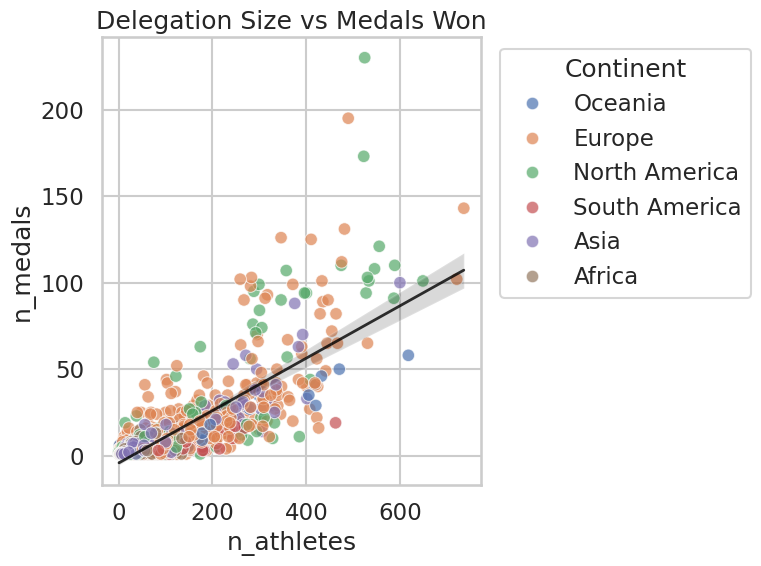

In [161]:
# Delagation size vs medals won
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=country_year,
    x="n_athletes",
    y="n_medals",
    hue="continent",
    alpha=0.7
)
plt.title("Delegation Size vs Medals Won")
plt.xlabel("Number of Athletes")
plt.ylabel("Number of Medals")

sns.regplot(
    data=country_year,
    x="n_athletes",
    y="n_medals",
    scatter=False,
    color="black",
    line_kws={"linewidth": 2, "alpha": 0.8}
)
plt.legend(title="Continent", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

Countries with larger delegations tend to win more medals, which shows a strong positive relationship between delegation size and meda count.  There is a bit of variation but the overall trend indicates that more atheletes increases the amount of medals a nations wins.

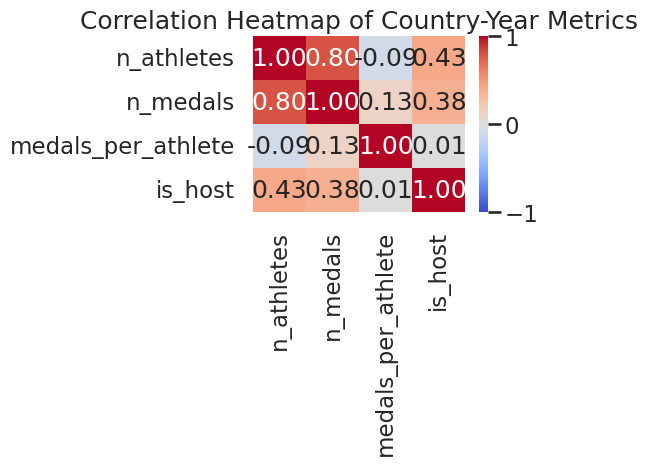

In [162]:
country_year.columns

num_cols = [
    "n_athletes",
    "n_medals",
    "medals_per_athlete",
    "is_host",
]

corr = country_year[num_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1
)
plt.title("Correlation Heatmap of Country-Year Metrics")
plt.tight_layout()
plt.show()

Medal count is strongly correlated with delegation size, while medal efficiency has a weaker relationship with the other variables.  Host status doesn't have much correlation with any metric either, which suggests that the host advantage is subtle and not 

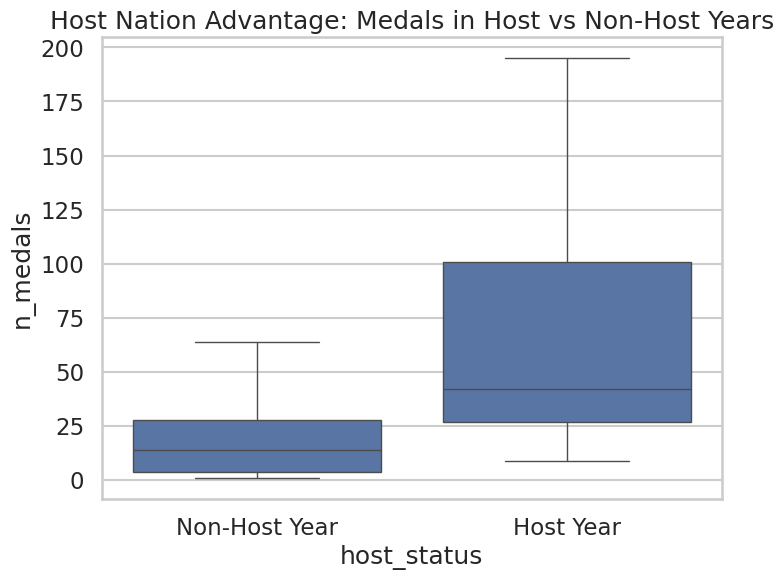

In [170]:
host_countries = country_year[country_year["is_host"] == 1]["country_name"].unique()
host_panel = country_year[country_year["country_name"].isin(host_countries)].copy()
host_panel["host_status"] = np.where(host_panel["is_host"] == 1, "Host Year", "Non-Host Year")

plt.figure(figsize=(8,6))
sns.boxplot(data=host_panel, x="host_status", y="n_medals", showfliers=False)
plt.title("Host Nation Advantage: Medals in Host vs Non-Host Years")
plt.show()

Host nations seem to win more medals in the years they host the olympics compared to all the other years they don't host.  This suggests that there is a advantage to being a host nation.

In [171]:
# choropleth map of total medals
total_medals_country = (
    country_year
    .groupby("country_name", as_index=False)["n_medals"]
    .sum()
)

# avoid weird values by adding a log-transformed version
total_medals_country["log_medals"] = np.log1p(total_medals_country["n_medals"])

fig = px.choropleth(
    total_medals_country,
    locations="country_name",
    locationmode="country names",
    color="log_medals",          
    hover_name="country_name",
    hover_data={"n_medals": True, "log_medals": False},
    color_continuous_scale="Viridis",
    title="Total Summer Olympic Medals by Country (1912+)",
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(
        title="log(1 + medals)"
    )
)

fig.show()

/tmp/ipykernel_230/2733476659.py:11: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



Countries like the Unites States, Russia, and some European countries seem to be the most dominant medal winners historically.  This global distribution shows the disparity between nations when it comes to Olympic success.

## Models

### Question 1. How has and is athlete participation changed across countries and continents?
To analyze how Olympic athlete particpation chaged over time we fist aggregated the total number of unique athletes for each Olympic year. 

Then we fit a linear model Total Athletes = B0 + B1 * Year

Cross-validated R^2: -8.2555236018481


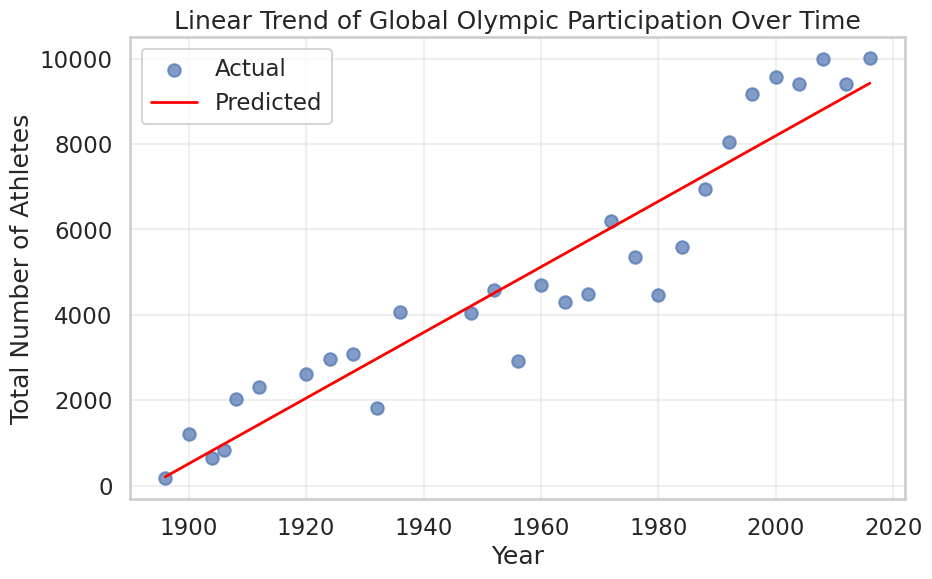

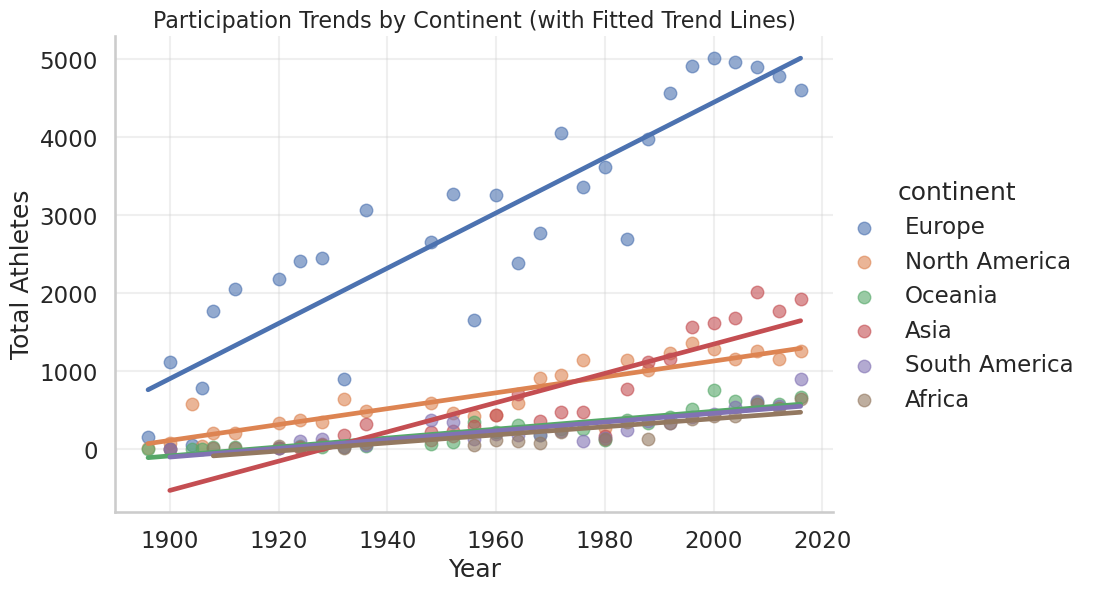

Intercept: -145442.40786473645
Slope: 76.81752190753511
       Continent  All_Time_Slope  Recent_Slope
0         Europe       35.423883     44.601515
1  North America       10.178347     15.112121
2        Oceania        5.713415     13.100000
3           Asia       18.758426     43.795455
4  South America        5.611890     16.507576
5         Africa        5.181264     12.786364


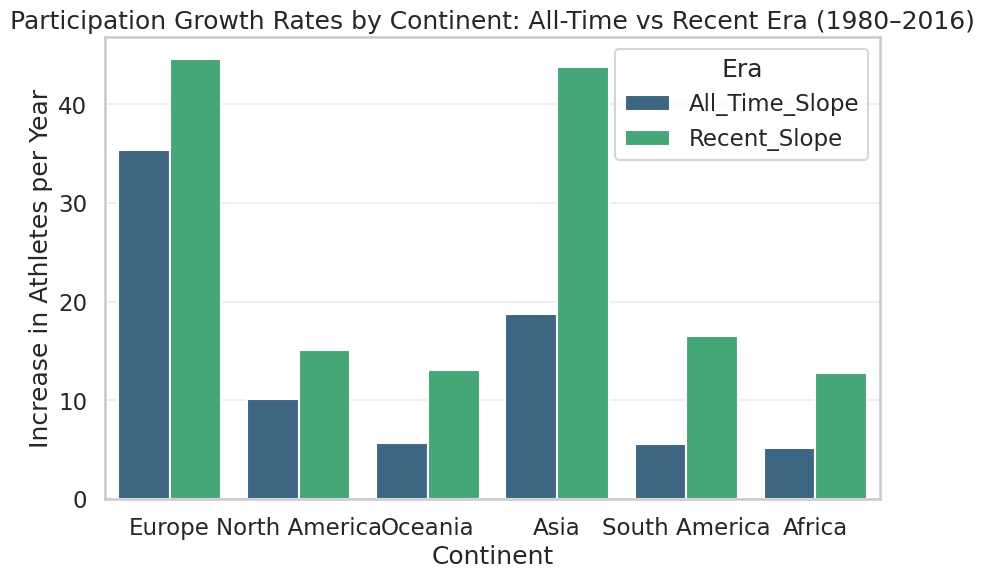

In [165]:
# regression model for predicinting how participation will change over time

participation_year = (
    country_year.groupby("Year")["n_athletes"]
    .sum()
    .reset_index()
)

participation_year.head()

# X must be 2D; y must be 1D
X = participation_year[["Year"]]
y = participation_year["n_athletes"]

model = LinearRegression()
model.fit(X, y)

# Evaluate the model using cross-validated R²
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-validated R^2:", scores.mean())

# Plot the actual vs predicted trend
participation_year["predicted"] = model.predict(X)

plt.figure(figsize=(10,6))
plt.scatter(participation_year["Year"], participation_year["n_athletes"], label="Actual", alpha=0.7)
plt.plot(participation_year["Year"], participation_year["predicted"], color="red", label="Predicted", linewidth=2)

plt.title("Linear Trend of Global Olympic Participation Over Time")
plt.xlabel("Year")
plt.ylabel("Total Number of Athletes")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

participation_continent = (
    country_year.dropna(subset=["continent"])
                .groupby(["Year", "continent"])["n_athletes"]
                .sum()
                .reset_index()
)

sns.lmplot(
    data=participation_continent,
    x="Year",
    y="n_athletes",
    hue="continent",
    height=6,
    aspect=1.5,
    ci=None,
    scatter_kws={"alpha":0.6}
)

plt.title("Participation Trends by Continent (with Fitted Trend Lines)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Total Athletes")
plt.grid(alpha=0.3)
plt.show()

# print model coefficients
print("Intercept:", model.intercept_)
print("Slope:", model.coef_[0])

# ALL TIME CONTINENT SLOPES
all_time_continent_slopes = {}

for cont in participation_continent["continent"].unique():
    df = participation_continent[participation_continent["continent"] == cont]
    Xc = df[["Year"]]
    yc = df["n_athletes"]
    reg = LinearRegression().fit(Xc, yc)
    all_time_continent_slopes[cont] = reg.coef_[0]

# RECENT SLOEPES
recent = participation_continent[participation_continent["Year"] >= 1980]

recent_slopes = {}

for cont in recent["continent"].unique():
    df = recent[recent["continent"] == cont]
    Xc = df[["Year"]]
    yc = df["n_athletes"]
    reg = LinearRegression().fit(Xc, yc)
    recent_slopes[cont] = reg.coef_[0]

slope_compare = pd.DataFrame({
    "Continent": all_time_continent_slopes.keys(),
    "All_Time_Slope": all_time_continent_slopes.values(),
    "Recent_Slope": [recent_slopes[c] for c in all_time_continent_slopes.keys()]
})

print(slope_compare)

slope_compare_melt = slope_compare.melt(
    id_vars="Continent",
    value_vars=["All_Time_Slope", "Recent_Slope"],
    var_name="Era",
    value_name="Slope"
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=slope_compare_melt,
    x="Continent",
    y="Slope",
    hue="Era",
    palette="viridis"
)
plt.title("Participation Growth Rates by Continent: All-Time vs Recent Era (1980–2016)")
plt.ylabel("Increase in Athletes per Year")
plt.xlabel("Continent")
plt.grid(axis="y", alpha=0.3)
plt.show()

#### Interpretation of Results
Athlete participation has dramatically increased over the past century. The linear model shows a strong upward trend. However, particpation is not explinaed well by a soley linear model. This makes sense as there are many things that can influence particpation from geopolitics to rule changes at the Olympics. 

The cross-validated R^2 of the linaer model is strongly negative, which means that a simple linear model is not appropriate for explaining global participation. A negative cross-validation R^2 means that it is worse than predicting the average participation every year. Still the fitted line shows a long-term increase in total athletes. Growth has not been smooth there are clear drops during World Wars, the 1980/1984 boycotts, and earlier years where participation was inconsistent. The model is unable to capture changes to qualification rules, World Wars, 1980/1984 boycotts, expalnsion of women participation, and an increase in team events.

To understand whether continents have grown equally we plotted continent specific regression lines. From the fitted lines we see that particpation increased across every continent but not at the same rate. Eurpoe had historically the largest athlete count but now its long term growth is smaller than recent growth. Asia has the strongest acceleration with its recent slope doubling its historical average. 


### Question 2. Does delegation size predict medal success? How strongly?
We used Random Forest Regression predicting total medal counts and viewing feature importance. 

Test R²: 0.8246188104848824
RMSE: 9.51592589164193


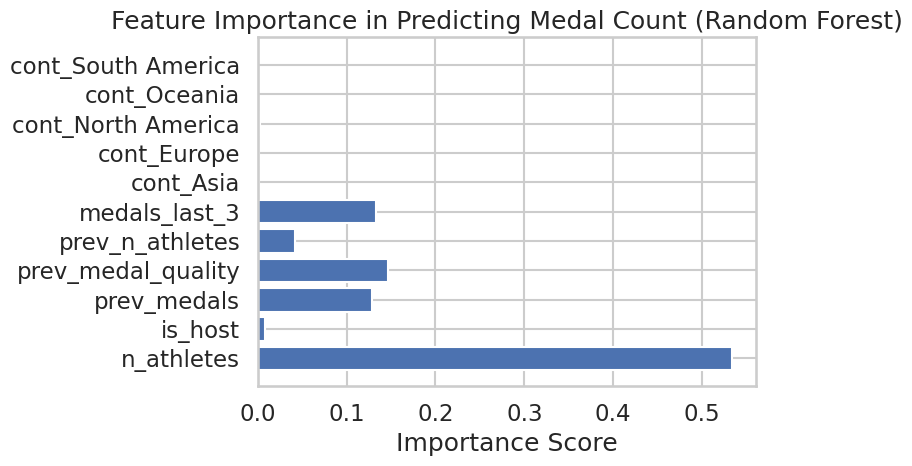

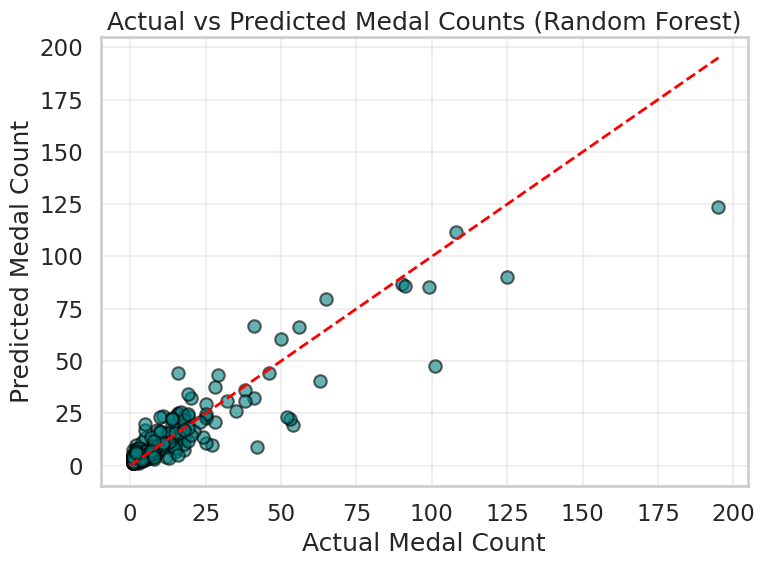

,country_name,n_medals,predicted_medals
1175,Algeria,2,2.240000
1176,Argentina,4,5.646667
1177,Armenia,4,3.436667
1178,Australia,29,43.130000
1179,Austria,1,2.090000
1180,Azerbaijan,18,7.726667
1181,Bahamas,2,1.963333
1186,Bahrain,2,1.796667
1184,Belarus,9,9.466667
1183,Belgium,6,5.263333


In [166]:
# ============================================
# Random Forest Model to Predict Medal Counts
# ============================================

model_df = country_year.dropna(subset=["continent"]).copy()
model_df = model_df.sort_values(["country_name", "Year"])

model_df["prev_medals"] = model_df.groupby("country_name")["n_medals"].shift(1)
model_df["prev_medal_quality"] = model_df.groupby("country_name")["total_medal_quality"].shift(1)
model_df["prev_n_athletes"] = model_df.groupby("country_name")["n_athletes"].shift(1)

# Rolling average of previous 3 Games
model_df["medals_last_3"] = (
    model_df.groupby("country_name")["n_medals"]
            .shift(1)                            # avoids data leakage
            .rolling(3, min_periods=1)
            .mean()
)

model_df = model_df.dropna( # drop rows with no olympic appearance before this
    subset=["prev_medals", "prev_medal_quality", "prev_n_athletes", "medals_last_3"]
)


X = model_df[[
    "n_athletes",
    "is_host",
    "prev_medals",
    "prev_medal_quality",
    "prev_n_athletes",
    "medals_last_3"
]]

X = pd.concat(
    [X, pd.get_dummies(model_df["continent"], prefix="cont", drop_first=True)], # one hot encoding for continents
    axis=1
)

y = model_df["n_medals"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)

print("Test R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Feature importance plot
importances = rf.feature_importances_
features = X.columns

plt.figure(figsize=(8,5))
plt.barh(features, importances)
plt.title("Feature Importance in Predicting Medal Count (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6)) 
plt.scatter(y_test, y_pred, alpha=0.6, color="teal", edgecolor="black") 
max_val = max(y_test.max(), y_pred.max()) 
plt.plot([0, max_val], [0, max_val], linestyle="--", color="red", linewidth=2) 
plt.title("Actual vs Predicted Medal Counts (Random Forest)") 
plt.xlabel("Actual Medal Count") 
plt.ylabel("Predicted Medal Count") 
plt.grid(alpha=0.3) 
plt.tight_layout() 
plt.show() 

pred_last = model_df[model_df["Year"] == 2016].copy()  # we compare it to 2016 is this statistcally sound (?)
X_last = X.loc[pred_last.index] 
pred_last["predicted_medals"] = rf.predict(X_last) 
pred_last[["country_name", "n_medals", "predicted_medals"]].head(10)


#### Interpretation of Results
Our model achieved a test R^2 = 0.866. This means that our model explains ~87% of variation in medal counts across all countries per year. This is a pretty strong predictive performance.

The RMSE = ~8 medals, which means that on average predicted medal counts are within 8 medals of true values. This is a small error relative to the 0-200 medal range. It shows that medal performance is very predictiable using just delegation size and recent history. Obviously, this model does have some flaws like when a nation is a host nation...

Looking at the feature importance we can see that number of athletes (n_athletes) is the most importance equal to ~.39. This has the largest effect on the amount of medals won meaning that bigger delegations win more medals. 

Medals in the last 3 Olympics (medals_last_3) has an importance of ~.24. This means that recent historical performance strongly predictes future success. This makes sense as investing money into athletics won't disappear in a few years and will last.

The continent variables have importances near zero. This means that geography is not a meaningful predictor of medal count. Medal performance depends more on national investment and historical effort rather than continental region.

From this we can conlcude, that delegation size does strongly correlate to Olympic performance, but it isn't the only contributing factor. Success scales with investment and delegation size. Olympic succes s is persistent . Nations that win medals tend to keep winning because stable infrastructure and fudning.

Our actual vs predicted medal counts show that only extreme outliers deviate from our predictions.

### Question 3. Do host nations experience a measurable boost in performance?
We isolated all countries that have ever hosted the Summer Olympic Games and compared their number of medals in the hosting year and their number of medals in all non-hosting years. We compared them usign a two-sample t-test. This is valid because these two groups have unequal variance and sample sizes differ.

In [167]:
# t-test for host nation advantage

host_countries = country_year[country_year["is_host"] == 1]["country_name"].unique()

# Keep only rows for host countries (both host & non-host years)
host_panel = country_year[country_year["country_name"].isin(host_countries)].copy()

host_year_medals = host_panel[host_panel["is_host"] == 1]["n_medals"] # a country during the year it hosts the olympics
nonhost_year_medals = host_panel[host_panel["is_host"] == 0]["n_medals"] # the same countries during years they do not host

# performs an independent two-sample t-test
t_stat, p_value = ttest_ind(
    host_year_medals,
    nonhost_year_medals,
    equal_var=False
)

print("T-statistic:", t_stat)
print("P-value:", p_value)

print("Average medals (host year):", host_year_medals.mean())
print("Average medals (non-host years):", nonhost_year_medals.mean())


T-statistic: 4.145292633886345
P-value: 0.000271677818340327
Average medals (host year): 67.48275862068965
Average medals (non-host years): 22.8628841607565


#### Interpretation of Results

These results show that host nations win ~3x more medals when they host. This test also shows that the difference is stastically signficant with p-value < 0.001. The chance of observing a difference this large if hosting had no effect is 0.027%. Host nations win dramatically more medals in the years they host the Olympics. This is what we expects as nations usually boost investment and athlete participation in the Olympics when they are the host. Also, when a country is the hosting the Olympics they get guarantees on the number of athletes.

In question 2 the test showed that the is_host flag had very little importance, while number of athletes was very important. However, Random Forest measures how useful hosting is for predicting medals once we know delegation size and past results, while t-test measures how hosting changes a country's performance. Host countries get more athletes which leads to more medals. This makes number of athletes increase, which means that it gets explained by number of athletes shown in Random Forest. Thus, hosting does increase medal counts, but the effect is explained by bigger team size rather than hosting itself.

# Contributions Report
We all contributed equally to the project.

Owen: Worked on data collection, preparation, exploratory data analysis, and interpretations of the result. Also helped with statistical models.

Navdha: Primarily worked on creating the statistical models with visualizations and interpreting them using different techniques. Also created the slide presentation

Fatimah: Helped with data collection and interpreting the exploratory data analysis results.